## Core Workflow: Download Sentinel-1 and Sentinel-2 images
Purpose: Search and acquire Sentinel-1 and Sentinel-2 images for a given studay area and time period. The acquired images can be inspected for conditions such as cloud cover, haziness etc. Finally, the acquired images can be downloaded and stored in the path.
<br>
Requirements: This notebook uses `bronco.py` and `bronco_candidates.py`
<br>
<br>
*Date: 2018-09-12*
<br>
*Author: Taufiq Rashid*


### Import statements

In [1]:
# typical, comprehensive imports


import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf
import keras

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

sys.path.append('/home/Taufiq.Rashid/UrbanLandUse/utils')
print sys.path

import bronco
import bronco_candidates
reload(bronco)
reload(bronco_candidates)

Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Taufiq.Rashid/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Taufiq.Rashid/.ipython', '/home/Taufiq.Rashid/UrbanLandUse/utils']


<module 'bronco_candidates' from '/home/Taufiq.Rashid/UrbanLandUse/utils/bronco_candidates.pyc'>

### Set key variables

In [2]:
place = 'hyderabad'  # setting the study area

data_path='/data/steven/data/taufiq/'+place+'/'  

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=10  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'  
s1_resolution = 10  

### Load and inspect study area 

hyderabad Hyderabad
>>> ogrinfo -al -so /data/steven/data/taufiq/hyderabad/Hyderabad_studyArea.shp
INFO: Open of `/data/steven/data/taufiq/hyderabad/Hyderabad_studyArea.shp'
      using driver `ESRI Shapefile' successful.

Layer name: Hyderabad_studyArea
Metadata:
  DBF_DATE_LAST_UPDATE=2016-07-17
Geometry: Polygon
Feature Count: 1
Extent: (195959.428255, 1900659.020753) - (262570.313581, 1963477.496879)
Layer SRS WKT:
PROJCS["WGS_1984_UTM_Zone_44N",
    GEOGCS["GCS_WGS_1984",
        DATUM["WGS_1984",
            SPHEROID["WGS_84",6378137.0,298.257223563]],
        PRIMEM["Greenwich",0.0],
        UNIT["Degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["false_easting",500000.0],
    PARAMETER["false_northing",0.0],
    PARAMETER["central_meridian",81.0],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["latitude_of_origin",0.0],
    UNIT["Meter",1.0]]
Id: Integer (6.0)

>>> ogrinfo -al -so /data/steven/data/taufiq/hyderabad/Hyderabad_studyAreaEPSG43

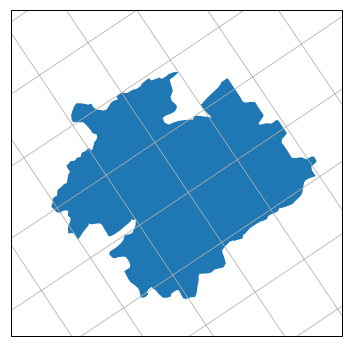

In [3]:
print place, place.title()  # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

bronco_candidates.info_studyareas(data_path, place)

shape = bronco_candidates.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
bbox = shape['bbox']

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (bbox[0]+bbox[2])/2.0, (bbox[1]+bbox[3])/2.0
print "center co-ordinates", clat, clon
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 458
[u'geometry', u'type', u'properties']
tile022 {u'type': u'Polygon', u'coordinates': [[[78.1775006012039, 17.529165535205387], [78.20460181878519, 17.52954978485592], [78.20420289377427, 17.555551127046854], [78.17709782110293, 17.55516627151902], [78.1775006012039, 17.529165535205387]]]}


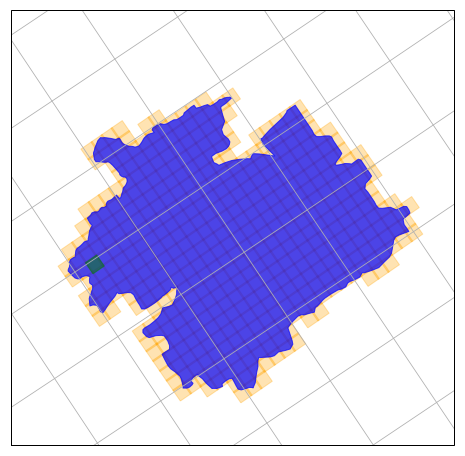

In [4]:
single_tile_id = 22
tiles = dl.raster.dltiles_from_shape(10.0, 256, 16, shape) 
bronco_candidates.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Search and acquire sentinel-2 imagery 

In [7]:
product = u'sentinel-2:L1C'
satellite='S2A'

#  Search metadata given a spatio-temporal query
feature_collection = dl.metadata.search(product=[product], start_time='2016-12-01', end_time='2017-01-01', 
                                        cloud_fraction_0=0.5, limit=75, geom=shape['geometry'])
s2_ids = [f['id'] for f in feature_collection['features']]
s2_ids.sort()
print len(s2_ids), s2_ids


7 [u'sentinel-2:L1C:2016-12-05_43QHV_98_S2A_v1', u'sentinel-2:L1C:2016-12-05_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-15_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-15_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-25_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-25_44QKE_99_S2A_v1', u'sentinel-2:L1C:2016-12-28_43QHV_30_S2A_v1']


### View image extents

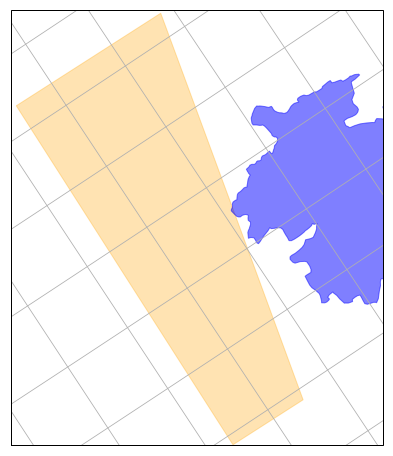

In [8]:
s2_imgs = s2_ids[6:7]

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

shapes = []
for s2_img in s2_imgs:
    metadata = dl.metadata.get(s2_img)
    shapes.append(shapely.geometry.shape(metadata['geometry']))

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='orange')
ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs, alpha=0.5, color='blue')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
bbox = union.bounds
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]),crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()


### Inspect imagery

[u'sentinel-2:L1C:2016-12-15_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-15_44QKE_99_S2A_v1'] (787, 841, 4)


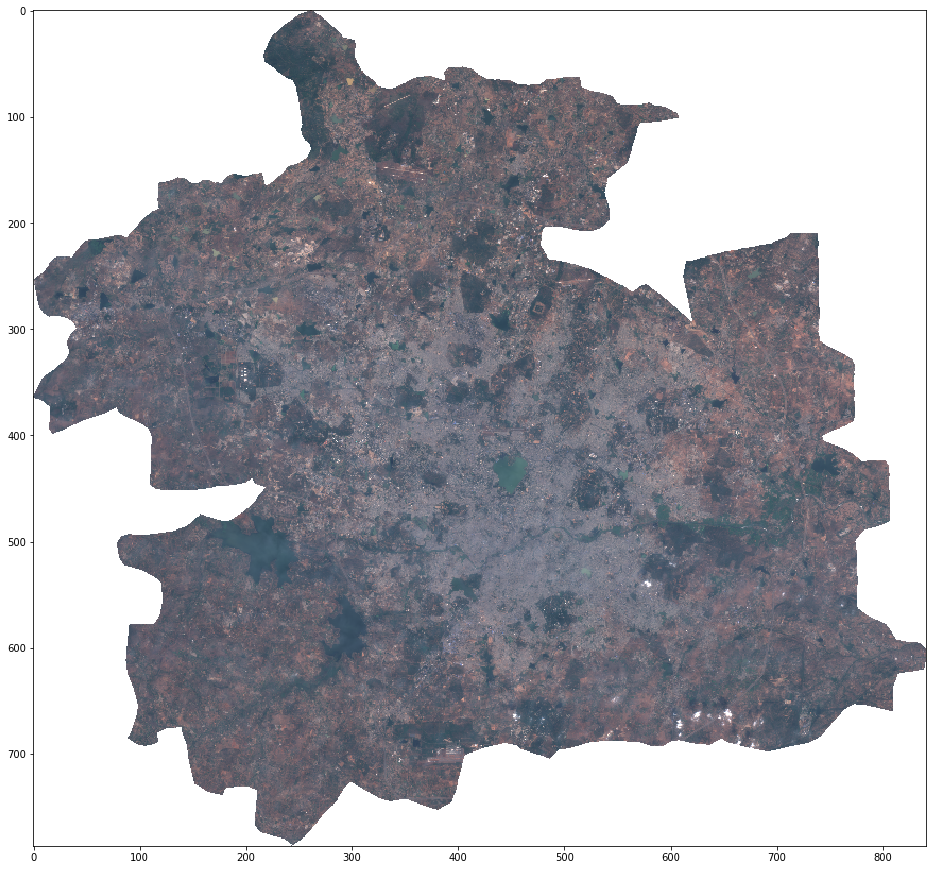

In [42]:
bronco.show_scene(s2_imgs[:],bands=['red','green','blue','alpha'],scales=[[0,3000],[0,3000],[0,3000],], geom=shape['geometry'], resolution=80)

### Download imagery 


In [36]:
# pull from api and save to file tiled images: sentinel-2 vir
s2_dict = {}

continue_index = 0

for vir_suffix, s2_imgs in s2_dict.iteritems():
    print vir_suffix, s2_imgs
    continue_index = 0

    for tile_id in range(len(tiles['features'])):
        if (tile_id < continue_index):
            print 'tile', tile_id, 'continuing'
            continue
        tile = tiles['features'][tile_id]
        print 'tile', tile_id, 'download VIR image'
        vir_band_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_vir_'+vir_suffix
        print vir_band_file
        sar = dl.raster.raster(
                s2_imgs,
                bands=bands,
                data_type='UInt16',
                dltile=tile,
                cutline=shape['geometry'],
                save=True,
                outfile_basename=vir_band_file)

J [u'sentinel-2:L1C:2016-12-25_43QHV_97_S2A_v1', u'sentinel-2:L1C:2016-12-25_44QKE_99_S2A_v1']
tile 0 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile000_vir_J_TEST
tile 1 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile001_vir_J_TEST
tile 2 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile002_vir_J_TEST
tile 3 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile003_vir_J_TEST
tile 4 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile004_vir_J_TEST
tile 5 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile005_vir_J_TEST
tile 6 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile006_vir_J_TEST
tile 7 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile007_vir_J_TEST
tile 8 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile008_vir_J_TEST
tile 9 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile009_vir_J_TEST
tile 

tile 90 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile090_vir_J_TEST
tile 91 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile091_vir_J_TEST
tile 92 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile092_vir_J_TEST
tile 93 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile093_vir_J_TEST
tile 94 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile094_vir_J_TEST
tile 95 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile095_vir_J_TEST
tile 96 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile096_vir_J_TEST
tile 97 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile097_vir_J_TEST
tile 98 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile098_vir_J_TEST
tile 99 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile099_vir_J_TEST
tile 100 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile100_vir_J_TES

tile 180 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile180_vir_J_TEST
tile 181 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile181_vir_J_TEST
tile 182 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile182_vir_J_TEST
tile 183 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile183_vir_J_TEST
tile 184 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile184_vir_J_TEST
tile 185 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile185_vir_J_TEST
tile 186 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile186_vir_J_TEST
tile 187 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile187_vir_J_TEST
tile 188 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile188_vir_J_TEST
tile 189 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile189_vir_J_TEST
tile 190 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile190

tile 270 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile270_vir_J_TEST
tile 271 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile271_vir_J_TEST
tile 272 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile272_vir_J_TEST
tile 273 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile273_vir_J_TEST
tile 274 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile274_vir_J_TEST
tile 275 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile275_vir_J_TEST
tile 276 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile276_vir_J_TEST
tile 277 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile277_vir_J_TEST
tile 278 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile278_vir_J_TEST
tile 279 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile279_vir_J_TEST
tile 280 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile280

tile 360 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile360_vir_J_TEST
tile 361 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile361_vir_J_TEST
tile 362 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile362_vir_J_TEST
tile 363 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile363_vir_J_TEST
tile 364 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile364_vir_J_TEST
tile 365 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile365_vir_J_TEST
tile 366 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile366_vir_J_TEST
tile 367 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile367_vir_J_TEST
tile 368 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile368_vir_J_TEST
tile 369 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile369_vir_J_TEST
tile 370 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile370

tile 450 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile450_vir_J_TEST
tile 451 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile451_vir_J_TEST
tile 452 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile452_vir_J_TEST
tile 453 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile453_vir_J_TEST
tile 454 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile454_vir_J_TEST
tile 455 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile455_vir_J_TEST
tile 456 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile456_vir_J_TEST
tile 457 download VIR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile457_vir_J_TEST


### Adjusting image files for UTM zone

In [ ]:
for tile_id in range(len(tiles['features'])):
    os.environ['ZRESULTTILE'] = data_path+place+'_tile'+str(tile_id).zfill(4)+'_vir_'+vir_suffix+'.tif' 
    !gdalinfo -proj4 $ZRESULTTILE | grep PROJCS

In [ ]:
for t in range(0, 6):
    os.environ['ZTILESOURCE'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before.tif'
    os.environ['ZTILERESULT'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before_15N.tif'
    !gdalwarp -t_srs '+proj=utm +zone=15 +datum=WGS84 +units=m +no_defs ' $ZTILESOURCE $ZTILERESULT

In [ ]:
for t in range(0, 6):
    os.environ['ZTILESOURCE'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before_15N.tif'
    os.environ['ZTILERESULT'] = data_path+place+'_tile'+str(t).zfill(4)+'_vir_before.tif'
    !mv $ZTILESOURCE $ZTILERESULT

### Mosaic the set of images

In [ ]:
!gdal_merge.py -n 255 -a_nodata 255 -o /data/steven/data/houston/houston_vir_before.tif /data/steven/data/houston/houston_tile????_vir_before.tif


### Search and acquire sentinel-1 imagery 

In [5]:
product= u'sentinel-1:GRD'
s1_satellite='SENTINEL-1A'

#  Search metadata given a spatio-temporal query
feature_collection = dl.metadata.search(product=[product], start_time='2016-01-01', end_time='2016-01-20', 
                                        limit=75, geom=shape['geometry'])
s1_ids = [f['id'] for f in feature_collection['features']]
s1_ids.sort()
print len(s1_ids), s1_ids

4 [u'sentinel-1:GRD:meta_2016-01-04_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-04_165D3854_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A']


### View image extents

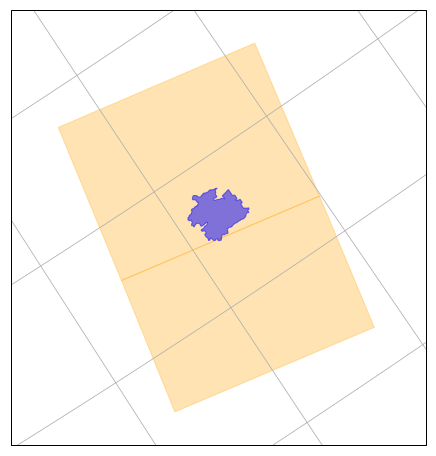

In [10]:
s1_imgs = s1_ids[2:4]
# view image extents 
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

# Get the geometry from each feature
shapes = []
for s1_img in s1_imgs:
    metadata = dl.metadata.get(s1_img)
    shapes.append(shapely.geometry.shape(metadata['geometry']))

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='orange')

ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs, alpha=0.5, color='blue')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
ax.set_extent((union.bounds[0], union.bounds[2], union.bounds[1], union.bounds[3]),crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()

### Inspect imagery

[u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A'] (785, 833, 3)


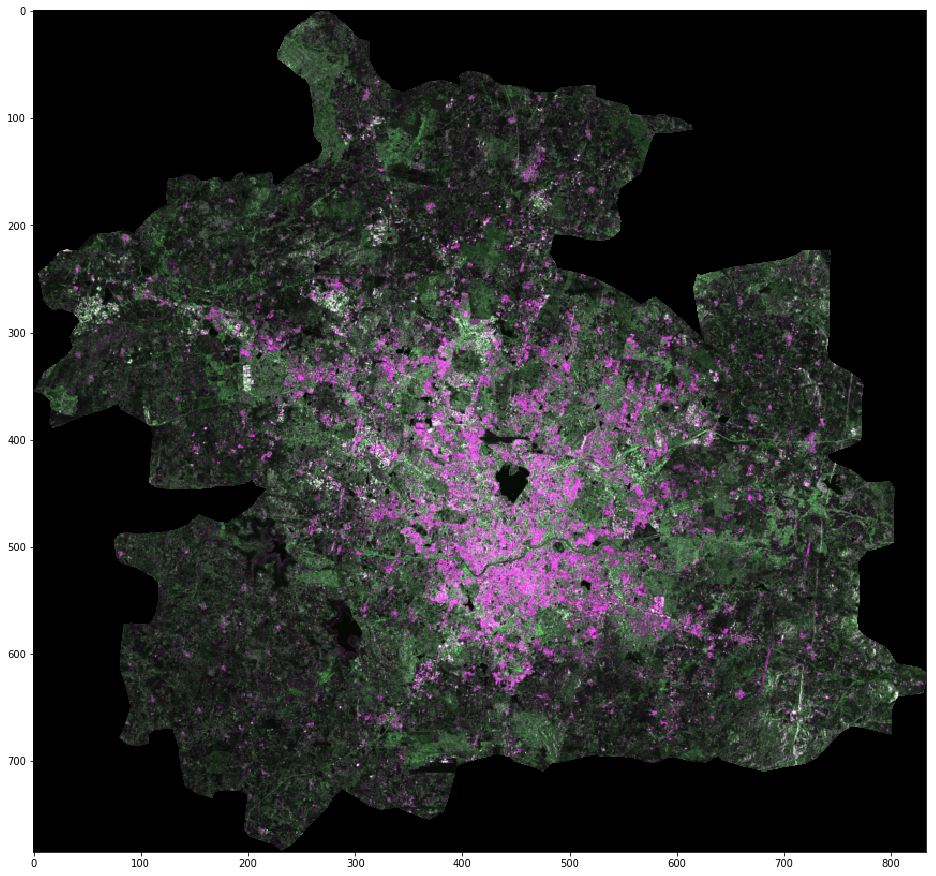

In [11]:
bronco.show_scene(s1_imgs[:], geom=shape['geometry'], resolution=80,bands=['vv','vh','vv'],scales=[[0,255],[0,255],[0,255]])

### Download imagery


In [12]:
# pull from api and save to file tiled images: sentinel-1 sar
s1_dict = {}
s1_dict['A'] = [u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A'] 

for sar_suffix, s1_imgs in s1_dict.iteritems():
    print sar_suffix, s1_imgs
    continue_index = 0

    for tile_id in range(len(tiles['features'])):
        if (tile_id < continue_index):
            print 'tile', tile_id, 'continuing'
            continue
        tile = tiles['features'][tile_id]
        print 'tile', tile_id, 'download SAR image'
        sar_band_file = data_path+place+'_tile'+str(tile_id).zfill(3)+'_sar_'+sar_suffix
        print sar_band_file
        sar = dl.raster.raster(
                s1_imgs,
                bands=s1_bands,
                data_type='UInt16',
                dltile=tile,
                cutline=shape['geometry'],
                save=True,
                outfile_basename=sar_band_file)

A [u'sentinel-1:GRD:meta_2016-01-16_165D3827_S1A', u'sentinel-1:GRD:meta_2016-01-16_165D3854_S1A']
tile 0 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile000_sar_A
tile 1 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile001_sar_A
tile 2 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile002_sar_A
tile 3 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile003_sar_A
tile 4 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile004_sar_A
tile 5 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile005_sar_A
tile 6 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile006_sar_A
tile 7 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile007_sar_A
tile 8 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile008_sar_A
tile 9 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile009_sar_A
tile 10 download SAR image
/data/steven/data/taufiq

tile 95 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile095_sar_A
tile 96 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile096_sar_A
tile 97 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile097_sar_A
tile 98 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile098_sar_A
tile 99 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile099_sar_A
tile 100 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile100_sar_A
tile 101 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile101_sar_A
tile 102 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile102_sar_A
tile 103 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile103_sar_A
tile 104 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile104_sar_A
tile 105 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile105_sar_A
tile 106 download SAR image
/data/steven/data/ta

tile 190 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile190_sar_A
tile 191 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile191_sar_A
tile 192 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile192_sar_A
tile 193 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile193_sar_A
tile 194 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile194_sar_A
tile 195 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile195_sar_A
tile 196 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile196_sar_A
tile 197 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile197_sar_A
tile 198 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile198_sar_A
tile 199 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile199_sar_A
tile 200 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile200_sar_A
tile 201 download SAR image
/data/steven/da

tile 285 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile285_sar_A
tile 286 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile286_sar_A
tile 287 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile287_sar_A
tile 288 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile288_sar_A
tile 289 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile289_sar_A
tile 290 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile290_sar_A
tile 291 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile291_sar_A
tile 292 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile292_sar_A
tile 293 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile293_sar_A
tile 294 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile294_sar_A
tile 295 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile295_sar_A
tile 296 download SAR image
/data/steven/da

tile 380 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile380_sar_A
tile 381 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile381_sar_A
tile 382 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile382_sar_A
tile 383 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile383_sar_A
tile 384 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile384_sar_A
tile 385 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile385_sar_A
tile 386 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile386_sar_A
tile 387 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile387_sar_A
tile 388 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile388_sar_A
tile 389 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile389_sar_A
tile 390 download SAR image
/data/steven/data/taufiq/hyderabad/hyderabad_tile390_sar_A
tile 391 download SAR image
/data/steven/da